In [99]:
# import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import random

In [101]:
#Some utility functions and classes

#import pandas as pd
#import random
#import json

class defect_imager():
    
    def __init__(self):
     
        #Where the processed annotations csv file is stored. 
        self.processed_annotation_path = "../data/processed_annotations.csv"
        # Main df
        self.annotations_df = pd.read_csv(self.processed_annotation_path)
        # List of all defect classes
        self.defect_classes = self.annotations_df['defect_class'].unique().tolist()
        # Count of each class in complete dataset.
        self.instance_count = dict(self.annotations_df['defect_class'].value_counts())
        self.example_dict = {}
        self.file_list = []
        self.bounding_boxes = []
        self.annotation_shape = []
        self.segmentations = []
        
    def n_instances(self, defect_class):
    # returns the number of instances in a given defect class
        
        return self.instance_count[defect_class]
        
    def load_n_examples(self, n, defect_class, shuffle=True, retn = True):
        
        #Clear any old data
        self.example_dict = {}
        
        # Check that the defect_class is in the df:
        if defect_class not in self.defect_classes:
            raise Exception(f"Class titled {defect_class} not found.")
        
        # Check that there are >=n examples within that class:
        if n > self.n_instances(defect_class):
            raise Exception(f"There are only {self.n_instance(defect_class)} examples of {defect_class}'s. Pick a smaller n'")
            
        #Create an index:
        n_elements = self.n_instances(defect_class)
        idx = range(0, n_elements)
        
        #Shuffle if required
        if shuffle:
            idx = [x for x in random.sample(idx, k = n_elements)][:n]
        else:
            idx = idx[:n]
            
        # Get a list of filenames       
        self.file_list = self.annotations_df['filename']\
            [self.annotations_df['defect_class']==defect_class]\
            .iloc[idx]\
            .tolist()
        
        # Get original segmentations
        self.segmentations = self.annotations_df['region_shape_attributes']\
            [self.annotations_df['defect_class']==defect_class]\
            .iloc[idx]\
            .tolist()
        
        # Get a list of bounding boxes
        self.bounding_boxes = self.annotations_df['bounding_box_coords']\
        [self.annotations_df['defect_class']==defect_class]\
            .iloc[idx]\
            .tolist()
        
        #I don't know why, but it is loading this list of lists as a list of strings.
        # This converts each string to a list. 
        self.bounding_boxes = [json.loads(x) for x in self.bounding_boxes]

        # Get a list of shapes
        self.annotation_shape = self.annotations_df['annotation_shape']\
            [self.annotations_df['defect_class']==defect_class]\
            .iloc[idx]\
            .tolist()
        
        # Write each example to the attribute
        for i in range(len(self.file_list)):
            self.example_dict.update(
                {f"{self.file_list[i]}":[
                    self.bounding_boxes[i], 
                    self.annotation_shape[i],
                    self.segmentations[i],
                ]}
            )
        
        if retn:
            return self.example_dict

    
def load_image(img_pth, img_name):
    #Load an image given the path and filename
    
    #Concatenate path and filename
    pth = img_pth + img_name
    #read image
    img = plt.imread(pth)
    
    return img

def get_coords(coord_list):
    #Returns the coordinates when using universal bounding boxes. 
    
    # Assumes format is [xmin, xmax, ymin, ymax]
    xmin = coord_list[0]
    xmax = coord_list[1]
    ymin = coord_list[2]
    ymax = coord_list[3]
    
    return [xmin, xmax-xmin, ymin, ymax-ymin]
    #return xmin, xmax - xmin, ymin, ymax - ymin

def get_bounding_box(rsa_dict):
    
    #Get a bounding box for each segmentation
    
    if 'name' in rsa_dict.keys():
    
        if rsa_dict['name'] == 'rect':
        # Coordinates for rectangle
            xmin = rsa_dict['x']
            xmax = rsa_dict['x'] + rsa_dict['width'] 
            ymin = rsa_dict['y'] 
            ymax = rsa_dict['y'] + rsa_dict['height'] 
            shape = rsa_dict['name']

        elif rsa_dict['name'] == 'polygon':
        #Coordinates for a polygon
            xmin = min(rsa_dict['all_points_x'])
            xmax = max(rsa_dict['all_points_x'])
            ymin = min(rsa_dict['all_points_y'])
            ymax = max(rsa_dict['all_points_y'])
            shape = rsa_dict['name']
            
        elif rsa_dict['name'] == 'circle':
        #coordinates for a circle
            xmin = rsa_dict['cx'] - rsa_dict['r']
            xmax = rsa_dict['cx'] + rsa_dict['r']
            ymin = rsa_dict['cy'] - rsa_dict['r']
            ymax = rsa_dict['cy'] + rsa_dict['r']
            shape = rsa_dict['name']
            
        elif rsa_dict['name'] == 'ellipse':
        # Coordinates for an ellipse
            xmin = rsa_dict['cx'] - rsa_dict['rx']
            xmax = rsa_dict['cx'] + rsa_dict['rx']
            ymin = rsa_dict['cy'] - rsa_dict['ry']
            ymax = rsa_dict['cy'] + rsa_dict['ry']
            shape = rsa_dict['name']
        
        #Write to tuple
        bbox = [xmin, xmax, ymin, ymax]
        
        
    else:
        # Some images have no annotation, return 4 pixels.
        bbox = [0, 0, 0, 0]
        shape = 'none'
    
    info = {"shape": shape, 'bbox':bbox}
    return info


def get_label(ra_dict):
    
    #Get the type of defect it is
    
    if 'Defect_Class' in ra_dict.keys():
    #Defects are annotated as <parent>_<defect> or <unknown>
        split_string = ra_dict['Defect_Class'].split('_')

        if len(split_string) < 2:
        #Captures the 'unkown'
            parent = split_string[0]
            defect = split_string[0]
        
        else:
        #Capture the true values we are interested.
            parent = split_string[0]
            defect = split_string[1]
        
    else:
    # No defect found
        parent = 'None'
        defect = 'None'
    
    return (parent, defect)

## EDA on the annotations

In [ ]:
# Path to images
im_pth = "../data/images/"
label_pth = "../data/labels/AnnotationsCombined.csv"
test_label_pth = "../data/labels/ucf_train_test/test_images.csv"

annotations = pd.read_csv(label_pth)
test_files = pd.read_csv(test_label_pth)
#annotations.head()

#Make a list of files in the test set
test_file_list = test_files.imagename.tolist()

### Process all segmentation coords as a bounding box

this will be useful when trying to do some simple visualisations

In [8]:
#Parse the region_shape_attribute column to get the coordinates of a bounding box
rsa = [get_bounding_box(x) for x in annotations.region_shape_attributes.apply(lambda x: json.loads(x))]

#Parse the region_attribute column to get the coordinates of the label name
ra = [get_label(x) for x in annotations.region_attributes.apply(lambda x: json.loads(x))]

# Check the dimensions are still OK (then we can presume still in order...)
if len(annotations) == len(ra) == len(rsa):

    #Create a new dataframe with parsed info:
    parsed_info = pd.DataFrame(
        {
            "annotation_shape": [x['shape'] for x in rsa],
            "bounding_box_coords": [x['bbox'] for x in rsa],
            "parent_label": [x[0] for x in ra],
            "defect_class": [x[1] for x in ra]
        }
    )

parsed_info.head()

,annotation_shape,bounding_box_coords,parent_label,defect_class
0,rect,"[120, 126, 201, 218]",Contact,NearSolderPad
1,rect,"[297, 300, 201, 226]",Contact,NearSolderPad
2,rect,"[325, 329, 200, 219]",Contact,NearSolderPad
3,rect,"[332, 337, 199, 218]",Contact,NearSolderPad
4,rect,"[288, 292, 296, 316]",Contact,FrontGridInterruption


In [10]:
# Join together on df index - note the data must be unshuffled!
combined_df = annotations.join(parsed_info)

# Write out
combined_df.to_csv('../data/processed_annotations.csv')
combined_df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,annotation_shape,bounding_box_coords,parent_label,defect_class
0,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,0,"{""name"":""rect"",""x"":120,""y"":201,""width"":6,""heig...","{""Defect_Class"":""Contact_NearSolderPad""}",rect,"[120, 126, 201, 218]",Contact,NearSolderPad
1,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,1,"{""name"":""rect"",""x"":297,""y"":201,""width"":3,""heig...","{""Defect_Class"":""Contact_NearSolderPad""}",rect,"[297, 300, 201, 226]",Contact,NearSolderPad
2,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,2,"{""name"":""rect"",""x"":325,""y"":200,""width"":4,""heig...","{""Defect_Class"":""Contact_NearSolderPad""}",rect,"[325, 329, 200, 219]",Contact,NearSolderPad
3,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,3,"{""name"":""rect"",""x"":332,""y"":199,""width"":5,""heig...","{""Defect_Class"":""Contact_NearSolderPad""}",rect,"[332, 337, 199, 218]",Contact,NearSolderPad
4,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,4,"{""name"":""rect"",""x"":288,""y"":296,""width"":4,""heig...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[288, 292, 296, 316]",Contact,FrontGridInterruption


In [11]:
combined_df[["filename","annotation_shape","bounding_box_coords","parent_label","defect_class"]].head()

,filename,annotation_shape,bounding_box_coords,parent_label,defect_class
0,Bent Cure 0Pa TestName_20201222_165250.586_C00...,rect,"[120, 126, 201, 218]",Contact,NearSolderPad
1,Bent Cure 0Pa TestName_20201222_165250.586_C00...,rect,"[297, 300, 201, 226]",Contact,NearSolderPad
2,Bent Cure 0Pa TestName_20201222_165250.586_C00...,rect,"[325, 329, 200, 219]",Contact,NearSolderPad
3,Bent Cure 0Pa TestName_20201222_165250.586_C00...,rect,"[332, 337, 199, 218]",Contact,NearSolderPad
4,Bent Cure 0Pa TestName_20201222_165250.586_C00...,rect,"[288, 292, 296, 316]",Contact,FrontGridInterruption


### Some stats on the dataset. 

In [12]:
# I want to know how many files gives how many instances by class

#Make a summary of the complete dataset
summary_1 = combined_df[['defect_class','filename']]\
    .groupby('defect_class')\
    .agg({"filename":['count', 'nunique']})\
    .reset_index()
summary_1.columns = ['defect_class','n_instances_all', 'n_files_all']
#summary_1

#Make a summary of the test dataset
test_data_summary = combined_df[combined_df['filename'].isin(test_file_list)]\
    [['defect_class','filename']]\
    .groupby('defect_class')\
    .agg({"filename":['count', 'nunique']})\
    .reset_index()
test_data_summary.columns = ['defect_class','n_instances_test', 'n_files_test']
#test_data_summary

#join and compare. 
tt_df = summary_1.merge(test_data_summary, left_on='defect_class', right_on = 'defect_class', how = 'left')\
            .fillna(0)
tt_df['pct_test'] = round(tt_df['n_instances_test'] / tt_df['n_instances_all'] * 100, 2)
tt_df[['defect_class', 'n_instances_all', 'n_instances_test', 'pct_test']]

,defect_class,n_instances_all,n_instances_test,pct_test
0,BeltMarks,16,0.0,0.00
1,BrightSpot,675,124.0,18.37
2,Closed,8464,1615.0,19.08
3,Corrosion,145,25.0,17.24
4,Disconnected,361,0.0,0.00
5,FrontGridInterruption,40511,7723.0,19.06
6,HighlyResistive,895,159.0,17.77
7,Isolated,4453,838.0,18.82
8,NearSolderPad,20359,4026.0,19.78
9,None,5236,0.0,0.00


In [13]:
## I want to see which shape of segmentation annotation corresponds to each defect, 
#filter count sort - summary of annotations
combined_df[['parent_label','defect_class','annotation_shape']]\
    .value_counts()\
    .reset_index()\
    .sort_values(['parent_label','defect_class'])

,parent_label,defect_class,annotation_shape,0
20,Contact,BeltMarks,rect,12
23,Contact,BeltMarks,polygon,4
11,Contact,Corrosion,polygon,138
22,Contact,Corrosion,rect,7
0,Contact,FrontGridInterruption,rect,38621
6,Contact,FrontGridInterruption,polygon,1890
1,Contact,NearSolderPad,rect,19153
7,Contact,NearSolderPad,polygon,1206
2,Crack,Closed,polygon,8376
13,Crack,Closed,rect,85


## Test visualisations

In [15]:
combined_df['defect_class'].unique().tolist()

['NearSolderPad',
 'FrontGridInterruption',
 'Closed',
 'Isolated',
 'Resistive',
 'None',
 'HighlyResistive',
 'BrightSpot',
 'Corrosion',
 'Unknown',
 'BeltMarks',
 'Disconnected']

In [63]:
combined_df[combined_df['defect_class'] == 'FrontGridInterruption']

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,annotation_shape,bounding_box_coords,parent_label,defect_class
4,Bent Cure 0Pa TestName_20201222_165250.586_C00...,37387,{},7,4,"{""name"":""rect"",""x"":288,""y"":296,""width"":4,""heig...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[288, 292, 296, 316]",Contact,FrontGridInterruption
13,Bent Cure 0Pa TestName_20201222_165250.586_C00...,36254,{},4,3,"{""name"":""rect"",""x"":303,""y"":35,""width"":4,""heigh...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[303, 307, 35, 45]",Contact,FrontGridInterruption
15,Bent Cure 0Pa TestName_20201222_165250.586_C00...,35892,{},2,1,"{""name"":""rect"",""x"":326,""y"":210,""width"":4,""heig...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[326, 330, 210, 215]",Contact,FrontGridInterruption
17,Bent Cure 0Pa TestName_20201222_165250.586_C00...,35951,{},9,1,"{""name"":""rect"",""x"":221,""y"":321,""width"":4,""heig...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[221, 225, 321, 339]",Contact,FrontGridInterruption
18,Bent Cure 0Pa TestName_20201222_165250.586_C00...,35951,{},9,2,"{""name"":""rect"",""x"":210,""y"":316,""width"":4,""heig...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[210, 214, 316, 342]",Contact,FrontGridInterruption
...,...,...,...,...,...,...,...,...,...,...,...
88841,M9002C001101.png,300501,{},16,11,"{""name"":""rect"",""x"":512,""y"":278,""width"":85,""hei...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[512, 597, 278, 293]",Contact,FrontGridInterruption
88842,M9002C001101.png,300501,{},16,12,"{""name"":""rect"",""x"":509,""y"":304,""width"":87,""hei...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[509, 596, 304, 316]",Contact,FrontGridInterruption
88843,M9002C001101.png,300501,{},16,13,"{""name"":""rect"",""x"":509,""y"":362,""width"":87,""hei...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[509, 596, 362, 388]",Contact,FrontGridInterruption
88844,M9002C001101.png,300501,{},16,14,"{""name"":""rect"",""x"":548,""y"":410,""width"":50,""hei...","{""Defect_Class"":""Contact_FrontGridInterruption""}",rect,"[548, 598, 410, 422]",Contact,FrontGridInterruption


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


M0631C022000.jpg
M0639C002000.jpg
M0631C038000.jpg
M0454C019100.jpg
M0637C020000.jpg


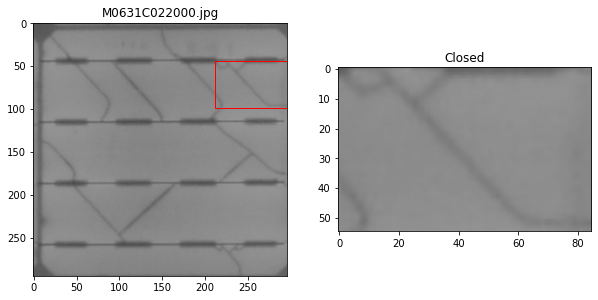

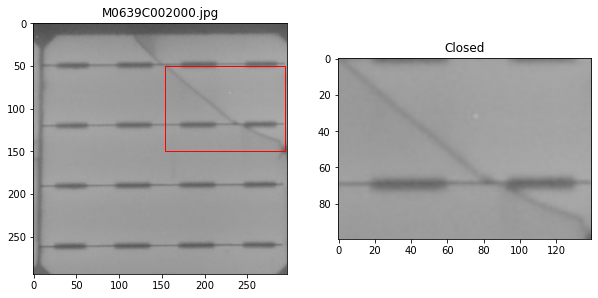

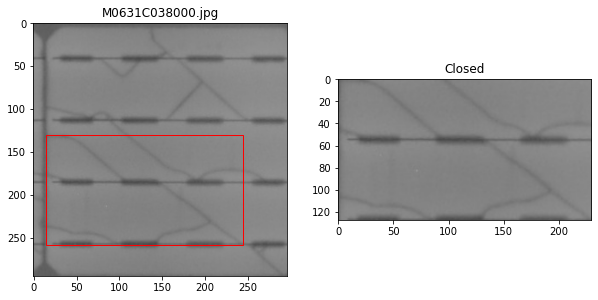

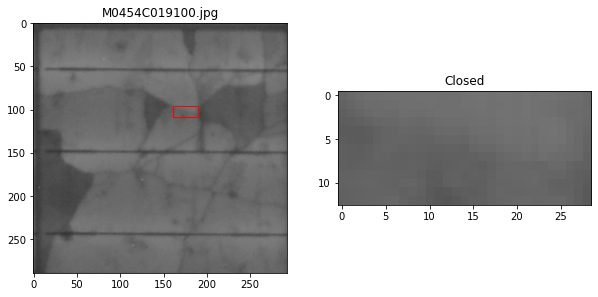

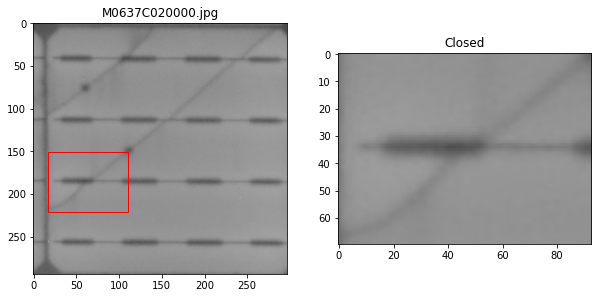

In [110]:
## Display n examples of a given class from different images at random. 

n_examples = 5
defect_class = 'Closed'

# Instantiate class    
imager = defect_imager()
# Load 10 examples of a closed crack
file_dict = imager.load_n_examples(n_examples, defect_class)  

for i in range(n_examples):

    # Load file
    img_name = imager.file_list[i]
    pth = f"../data/images/"
    img = load_image(pth, img_name)

    # Load bounding box coords
    x,w,y,h = get_coords(imager.bounding_boxes[i])


    #Plot
    fig, axs = plt.subplots(1,2,figsize=(10,10))

    # Create rectangle
    axs[0].set_title(img_name)
    axs[0].imshow(img)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)
    
    #Plot cropped. 
    axs[1].imshow(img[y:y+h, x:x+w])
    axs[1].set_title(defect_class)
    print(img_name)

## Enhancements:

- Plot proper segmentation polygons/elipses/boxes depending on type
- For a given image, plot the image with boxes around each segmentation. 
